In [31]:
import pandas as pd
import string

In [32]:
def replace_polish_lowercase(text):
    polish_to_latin = {
        'ą': 'a', 'ć': 'c', 'ę': 'e', 'ł': 'l', 'ń': 'n', 
        'ó': 'o', 'ś': 's', 'ź': 'z', 'ż': 'z'
    }
    return ''.join(polish_to_latin.get(char, char) for char in text)

def preprocess_text(text):
    # Lowercase
    text = text.lower()
    # Remove punctuation
    text = text.translate(str.maketrans('', '', string.punctuation))
    # Remove polish letters
    text = replace_polish_lowercase(text)
    # Tokenize (split by whitespace)
    tokens = text.split()
    return ' '.join(tokens)  # Join tokens back into a string for TF-IDF

In [33]:
FILENAME_DEV = './data/dataset_conll/all.sentence.dev.txt'
FILENAME_TRAIN = './data/dataset_conll/all.sentence.train.txt'
FILENAME_TEST = './data/dataset_conll/all.sentence.test.txt'

LABELS = {
    "__label__z_minus_m": "Negative sentiment", 
    "__label__z_plus_m": "Positive sentiment",
    "__label__z_zero": "No sentiment",
    "__label__z_amb": "Unsure",
    }

labels_map = {
        'Negative sentiment': 0,
        'Positive sentiment': 1,
        'No sentiment': 2,
        'Unsure': 3,

    }

In [34]:
def load_df(filename):
    with open(filename, 'r', encoding="utf8") as f:
        lines = f.readlines()
        data = [line.strip() for line in lines]
        # get last word from each item as a label and match with data
        labeled_data = []
        for item in data:
            label = item.split()[-1]
            sentence_data = ' '.join(item.split()[:-1])
            labeled_data.append((sentence_data, LABELS[label]))

        # create a dataframe
        df = pd.DataFrame(labeled_data, columns=['text', 'labels'])
        return df

# Read data

In [35]:
df_train = load_df(FILENAME_TRAIN)
df_test = load_df(FILENAME_TEST)

In [36]:
df_train['text'] = df_train['text'].apply(preprocess_text)
df_test['text'] = df_test['text'].apply(preprocess_text)

In [37]:
df_train.sample(5)

,text,labels
15768,obecnie nowotwory zlosliwe sa w polsce druga p...,No sentiment
20329,z doswiadczenia wiem ze jak ktos zadzwoni 4 si...,No sentiment
10536,w trakcie wizyty taktownie slucha umiejetnie d...,Positive sentiment
35903,po badaniu usg stwierdzil dysplazje obustronna...,No sentiment
20968,w ogole tylko jest jeden bar,Negative sentiment


# LSTM

In [38]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from collections import Counter
import numpy as np
import torch.nn.functional as F

In [39]:
class TextDataset(Dataset):
    def __init__(self, texts, labels, vocab, max_length=100):
        self.texts = texts
        self.labels = labels
        self.vocab = vocab
        self.max_length = max_length
        
    def __len__(self):
        return len(self.texts)
    
    def __getitem__(self, idx):
        text = self.texts[idx]
        label = labels_map[self.labels[idx]]
        
        # Convert text to indices
        indices = [self.vocab.get(word, self.vocab['<UNK>']) for word in text.split()]
        
        # Pad or truncate to max_length
        if len(indices) < self.max_length:
            indices = indices + [self.vocab['<PAD>']] * (self.max_length - len(indices))
        else:
            indices = indices[:self.max_length]
            
        return (torch.tensor(indices, dtype=torch.long), 
                torch.tensor(label, dtype=torch.long))

In [40]:
def build_vocab(texts, min_freq=2):
    # Count word frequencies
    word_counts = Counter()
    for text in texts:
        word_counts.update(text.split())
    
    # Create vocabulary
    vocab = {'<PAD>': 0, '<UNK>': 1}
    idx = 2
    for word, count in word_counts.items():
        if count >= min_freq:
            vocab[word] = idx
            idx += 1
    
    return vocab

In [41]:
def train_model(model, train_loader, val_loader, criterion, optimizer, n_epochs):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = model.to(device)
    
    for epoch in range(n_epochs):
        model.train()
        train_loss = 0
        train_correct = 0
        train_total = 0
        
        for texts, labels in train_loader:
            texts = texts.to(device)
            labels = labels.to(device)
            
            optimizer.zero_grad()
            logits = model(texts)
            loss = criterion(logits, labels)
            
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item()
            _, predicted = torch.max(logits, 1)
            train_correct += (predicted == labels).sum().item()
            train_total += labels.size(0)
        
        model.eval()
        val_loss = 0
        val_correct = 0
        val_total = 0
        
        with torch.no_grad():
            for texts, labels in val_loader:
                texts = texts.to(device)
                labels = labels.to(device)
                
                logits = model(texts)
                loss = criterion(logits, labels)
                
                val_loss += loss.item()
                _, predicted = torch.max(logits, 1)
                val_correct += (predicted == labels).sum().item()
                val_total += labels.size(0)

        
        print(f'Epoch {epoch+1}/{n_epochs}:')
        print(f'Training Loss: {train_loss/len(train_loader):.4f}, Accuracy: {100*train_correct/train_total:.2f}%')
        print(f'Validation Loss: {val_loss/len(val_loader):.4f}, Accuracy: {100*val_correct/val_total:.2f}%')

In [42]:
class SentimentLSTM(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, n_layers, num_classes, dropout_rate=0.5):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.embed_dropout = nn.Dropout(dropout_rate)
        
        self.lstm = nn.LSTM(
            embedding_dim, 
            hidden_dim, 
            n_layers, 
            batch_first=True,
            bidirectional=True,
            dropout=dropout_rate if n_layers > 1 else 0
        )
        
        self.batch_norm = nn.BatchNorm1d(hidden_dim * 2)  # *2 for bidirectional
        self.dropout = nn.Dropout(dropout_rate)
        self.fc = nn.Linear(hidden_dim * 2, num_classes)
        
    def forward(self, text):
        text = text.long()
        
        embedded = self.embedding(text)
        embedded = self.embed_dropout(embedded)
        
        lstm_out, _ = self.lstm(embedded)
        lstm_out = lstm_out[:, -1, :]
        lstm_out = self.batch_norm(lstm_out)
        lstm_out = self.dropout(lstm_out)
        
        return self.fc(lstm_out)

In [45]:
vocab = build_vocab(df_train["text"].to_numpy())

train_dataset = TextDataset(df_train["text"].to_numpy(), df_train["labels"].to_numpy(), vocab)
val_dataset = TextDataset(df_test["text"].to_numpy(), df_test["labels"].to_numpy(), vocab)

batch_size = 256
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)

model = SentimentLSTM(
        vocab_size=len(vocab),
        embedding_dim=100,
        hidden_dim=64,
        n_layers=2,
        num_classes=4,
        dropout_rate=0.4
    )
# best params:
# model = SentimentLSTM(
#         vocab_size=len(vocab),
#         embedding_dim=100,
#         hidden_dim=64,
#         n_layers=2,
#         num_classes=4,
#         dropout_rate=0.4
#     )
# epochs = 30
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters())

In [46]:
train_model(model, train_loader, val_loader, criterion, optimizer, n_epochs=30)

Epoch 1/30:
Training Loss: 1.3927, Accuracy: 30.53%
Validation Loss: 1.3225, Accuracy: 36.95%
Epoch 2/30:
Training Loss: 1.3348, Accuracy: 35.31%
Validation Loss: 1.3216, Accuracy: 36.95%
Epoch 3/30:
Training Loss: 1.3276, Accuracy: 36.19%
Validation Loss: 1.3183, Accuracy: 36.97%
Epoch 4/30:
Training Loss: 1.3252, Accuracy: 36.39%
Validation Loss: 1.3190, Accuracy: 36.95%
Epoch 5/30:
Training Loss: 1.3245, Accuracy: 36.65%
Validation Loss: 1.3182, Accuracy: 36.95%
Epoch 6/30:
Training Loss: 1.3244, Accuracy: 36.37%
Validation Loss: 1.3183, Accuracy: 36.95%
Epoch 7/30:
Training Loss: 1.3240, Accuracy: 36.59%
Validation Loss: 1.3191, Accuracy: 36.95%
Epoch 8/30:
Training Loss: 1.3232, Accuracy: 36.70%
Validation Loss: 1.3182, Accuracy: 36.95%
Epoch 9/30:
Training Loss: 1.3235, Accuracy: 36.67%
Validation Loss: 1.3188, Accuracy: 36.95%
Epoch 10/30:
Training Loss: 1.3229, Accuracy: 36.68%
Validation Loss: 1.3187, Accuracy: 36.95%
Epoch 11/30:
Training Loss: 1.3227, Accuracy: 36.66%
Valida

LSTM Accuracy: 0.70
LSTM Precision: 0.70
LSTM Recall: 0.70
LSTM F1: 0.69


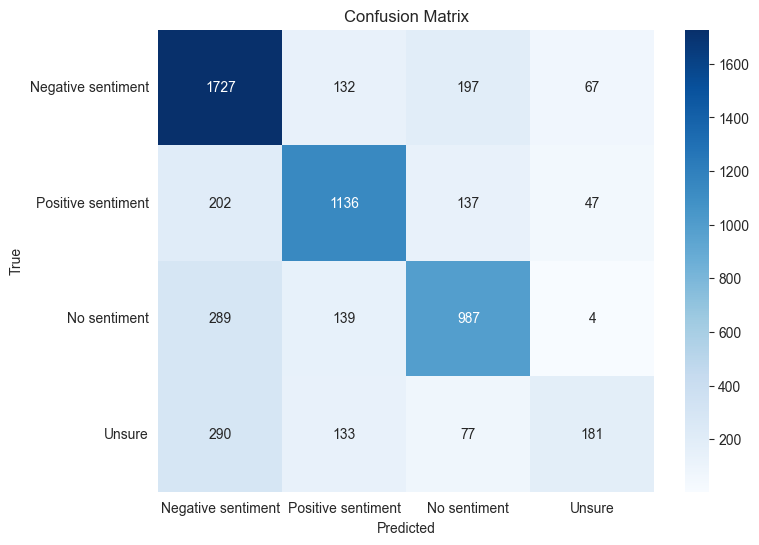

In [48]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix
import torch
from util import model_summary, save_model_summary_dict, show_model_summary_dict

# Ustaw urządzenie

def evaluate_model(model, val_loader, criterion):
    model.eval()
    all_preds = []
    all_labels = []
    total_loss = 0

    with torch.no_grad():
        for texts, labels in val_loader:
            # Przenieś dane na to samo urządzenie co model
            texts, labels = texts.to(device), labels.to(device)

            # Forward pass
            outputs = model(texts)
            loss = criterion(outputs, labels)
            total_loss += loss.item()

            # Predictions
            preds = torch.argmax(outputs, dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Calculate metrics
    summary = model_summary(all_labels, all_preds, list(LABELS.values()), "LSTM", is_y_indices=True)
    save_model_summary_dict(summary)
    show_model_summary_dict(summary)

# Wywołanie funkcji ewaluacyjnej
evaluate_model(model, val_loader, criterion)

True
